# Covid 19 Regression

Team Members:
- Vu hong Phuc - V202000127
- Nguyen Duy Minh
- Nguyen Truong Giang

## Table of Content
1. Data Preprocessing
2. Regression and Diagnostics for 2 tasks
3. P-value Interpretation
4. Step-wise forward regression
5. Step-wise backward regression
6. Difference between forward and backward regression

# 1. Data Preprocessing

In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import defaultdict
import seaborn as sns


from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [56]:
df = pd.read_csv(r'./owid-2022-clean.csv')
df.sample(n=5)

,iso_code,continent,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests_smoothed_per_thousand,positive_rate,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
200,BDI,Africa,Burundi,2/5/2022,3064.927,0.000,3.101,0.000,0.222,0.0138,...,702.225,71.7,293.068,6.05,NaN,NaN,6.144,0.8,61.58,0.433
981,LCA,North America,Saint Lucia,2/2/2022,114321.506,753.792,1805.847,27.115,NaN,NaN,...,12951.839,NaN,204.620,11.62,NaN,NaN,87.202,1.3,76.20,0.759
627,KEN,Africa,Kenya,2/5/2022,5856.850,2.201,101.972,0.055,0.069,0.0303,...,2993.028,36.8,218.637,2.92,1.2,20.4,24.651,1.4,66.70,0.601
1070,SVN,Europe,Slovenia,2/7/2022,384857.434,2679.049,2881.577,7.216,50.511,0.1210,...,31400.840,NaN,153.493,7.25,20.1,25.0,NaN,4.5,81.32,0.917
617,KAZ,Asia,Kazakhstan,2/2/2022,70566.621,408.898,976.417,1.000,NaN,NaN,...,24055.588,0.1,466.792,7.11,7.0,43.1,98.999,6.7,73.60,0.825


## 1.1 Feature Selection

### Remove irrelevant fields as in instructions
- location
- total_deaths_per_million 
- total_cases_per_million
- population
- tests_units

In [57]:
# Drop irrelevant fields
print(df.columns.shape)
df.drop(["location", "total_deaths_per_million", "total_cases_per_million", "population", "tests_units"], axis=1, inplace=True)
print(df.columns.shape)

(31,)
(26,)


### Then check which features have too many missing values

In [58]:
for col_name, col_data in df.iteritems():
    num_null = col_data.isnull().sum()
    if num_null >= len(df)//2:
        print(f"{col_name}: {num_null}/{len(df)}")
        


people_vaccinated_per_hundred: 734/1323
people_fully_vaccinated_per_hundred: 717/1323
total_boosters_per_hundred: 856/1323
handwashing_facilities: 672/1323


### We can see that there are 4 features that half of them are missing values. However, these features may be a good indicator for prediction; thus, we need to look into each continent and their relationship with other variable for more insights

In [59]:
df_group_iso = df.groupby(["iso_code"])
df_group_cont = df.groupby(["continent"])

null_feat = defaultdict(int)
for cont, data in df_group_cont:
    print(f"{cont}:")
    for cols_name, col_data in data.iteritems():
        num_null = col_data.isnull().sum()
        if num_null >= len(col_data)//2:
            null_feat[cols_name] += 1
            print(f"{cols_name:<50}:\t {num_null}/{len(data)}")
            

    print()




Africa:
people_vaccinated_per_hundred                     :	 298/378
people_fully_vaccinated_per_hundred               :	 300/378
total_boosters_per_hundred                        :	 352/378

Asia:
total_boosters_per_hundred                        :	 191/329

Europe:
handwashing_facilities                            :	 273/294

North America:
people_vaccinated_per_hundred                     :	 104/175
people_fully_vaccinated_per_hundred               :	 105/175
total_boosters_per_hundred                        :	 123/175
extreme_poverty                                   :	 98/175
male_smokers                                      :	 91/175

Oceania:
new_tests_smoothed_per_thousand                   :	 42/63
positive_rate                                     :	 56/63
tests_per_case                                    :	 56/63
people_vaccinated_per_hundred                     :	 42/63
people_fully_vaccinated_per_hundred               :	 42/63
total_boosters_per_hundred                     

### Continents share the several features with many NaN values and some are specific to that continent so that we need to decide whether it is worth to keep these features and drop countries with too many missng values or we can drop that features and keep the country because it is not neccesarily a good indicator.

### Next we will look into the correlation between variables with respect to continent to spot dependent features

### First we inpect "age" group 

In [60]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

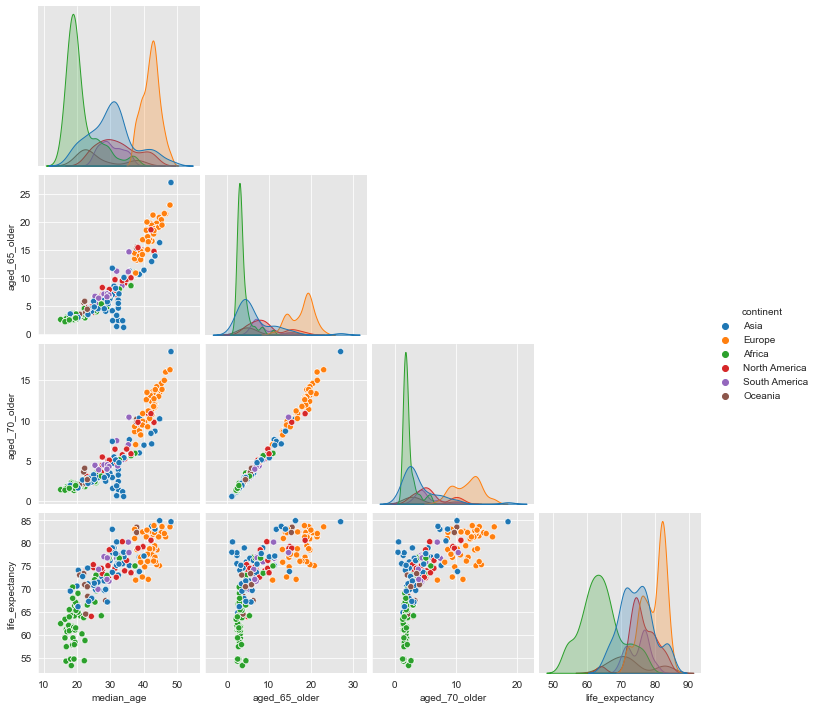

In [61]:
age_cols = ["continent", 
            "median_age", 
            "aged_65_older", 
            "aged_70_older", 
            "life_expectancy"]
df_age = df.loc[:, age_cols]
sns.pairplot(df_age, hue="continent", corner=True)

In [62]:
df["aged_70_older"].corr(df["aged_65_older"])

0.9946122663675626

### In the graph above, there is a high correlation (around 0.99) between ```aged_65_older``` and ```aged_70_older```, thus we can remove ```aged_70_older``` from prediction model


In [63]:
df.drop(["aged_70_older"], inplace=True, axis=1)

### Next, we inspect booster group as many booster features have too many missing values as shown above

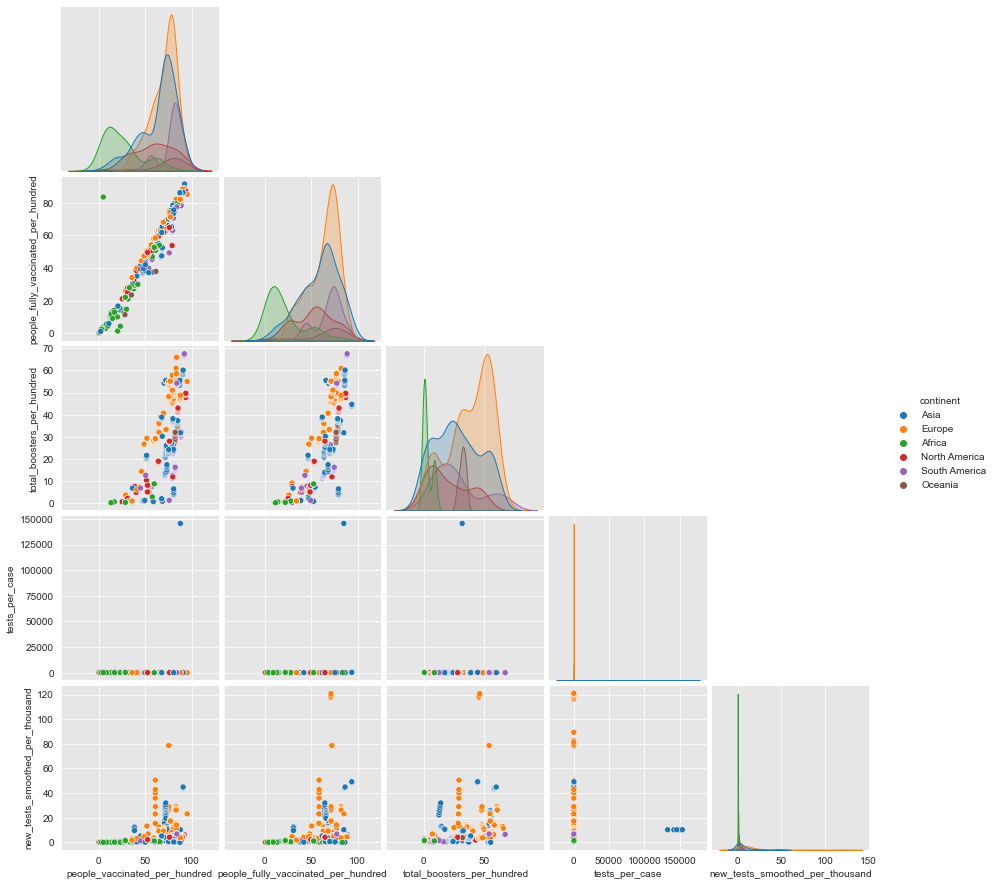

In [64]:
boost_cols = [
    "continent", 
    "people_vaccinated_per_hundred", 
    "people_fully_vaccinated_per_hundred", 
    "total_boosters_per_hundred", 
    "tests_per_case", 
    "new_tests_smoothed_per_thousand"] 

df_boost = df.loc[:, boost_cols]
sns.pairplot(df_boost, hue="continent", corner=True)

In [65]:
df["people_fully_vaccinated_per_hundred"].corr(df["total_boosters_per_hundred"])

0.794440276907046

In [66]:
df["people_fully_vaccinated_per_hundred"].corr(df["people_vaccinated_per_hundred"])



0.9712407852959766

### In the graph above, there is a high correlation between ```people_vaccinated_per_hundred```, ```people_fully_vaccinated_per_hundred```, and ```total_boosters_per_hundred```. Also these 2 removed features are also in the list of features with many missing values. Thus we can remove ```people_vaccinated_per_hundred``` and ```total_boosters_per_hundred``` from prediction model.

In [67]:
df.drop(["people_vaccinated_per_hundred", "total_boosters_per_hundred"], inplace=True, axis=1)

### Next, we inspect standard of living group to see if we can remove handwahsing facilities feature as it has many missing values in several continents

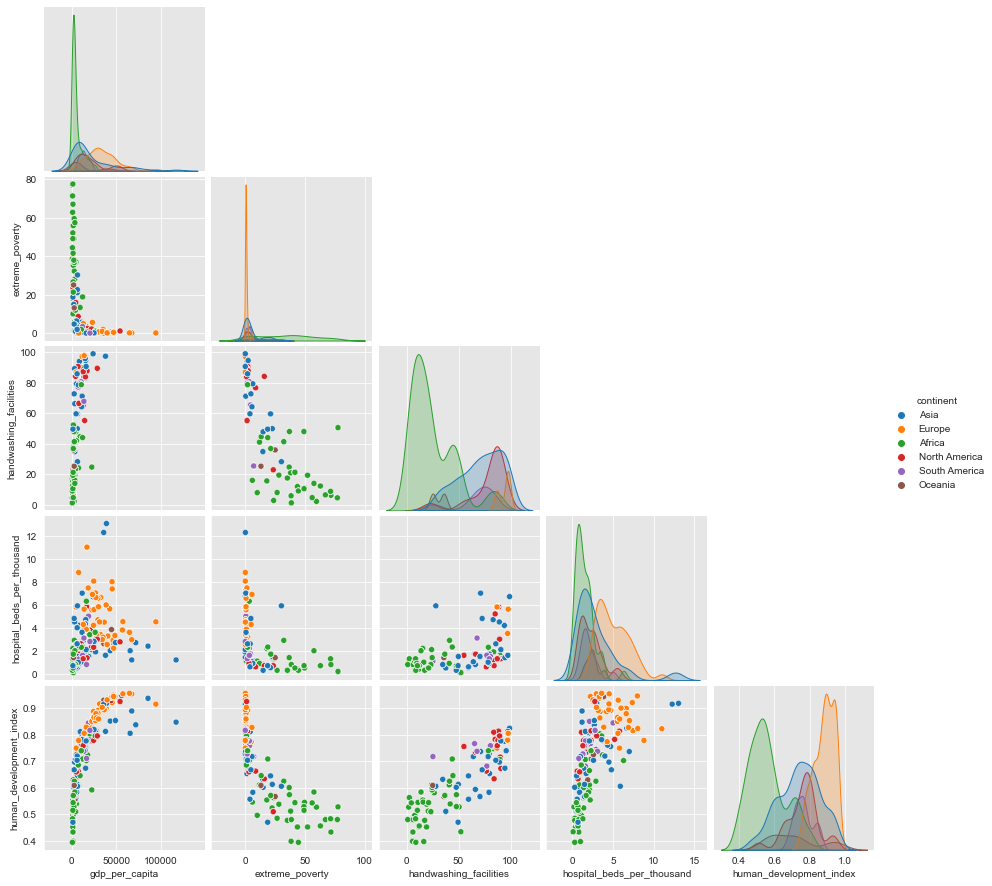

In [68]:
live_cols = [
    "continent", 
    "gdp_per_capita", 
    "extreme_poverty", 
    "handwashing_facilities", 
    "hospital_beds_per_thousand", 
    "human_development_index"] 

df_live = df.loc[:, live_cols]
sns.pairplot(df_live, hue="continent", corner=True)

In [69]:
df["handwashing_facilities"].corr(df["human_development_index"])

0.8357207690377708

### we can see that there is a high correlation (around 0.83) between ```handwashing_facilities``` and ```human_development_index```

### Moreover, ```handwashing_facilities``` has many missing values and ```human_development_index``` is a more holistic feature, thus we can remove ```handwashing_facilities``` from prediction model.


In [70]:
df.drop(["handwashing_facilities"], inplace=True, axis=1)

### Health Category

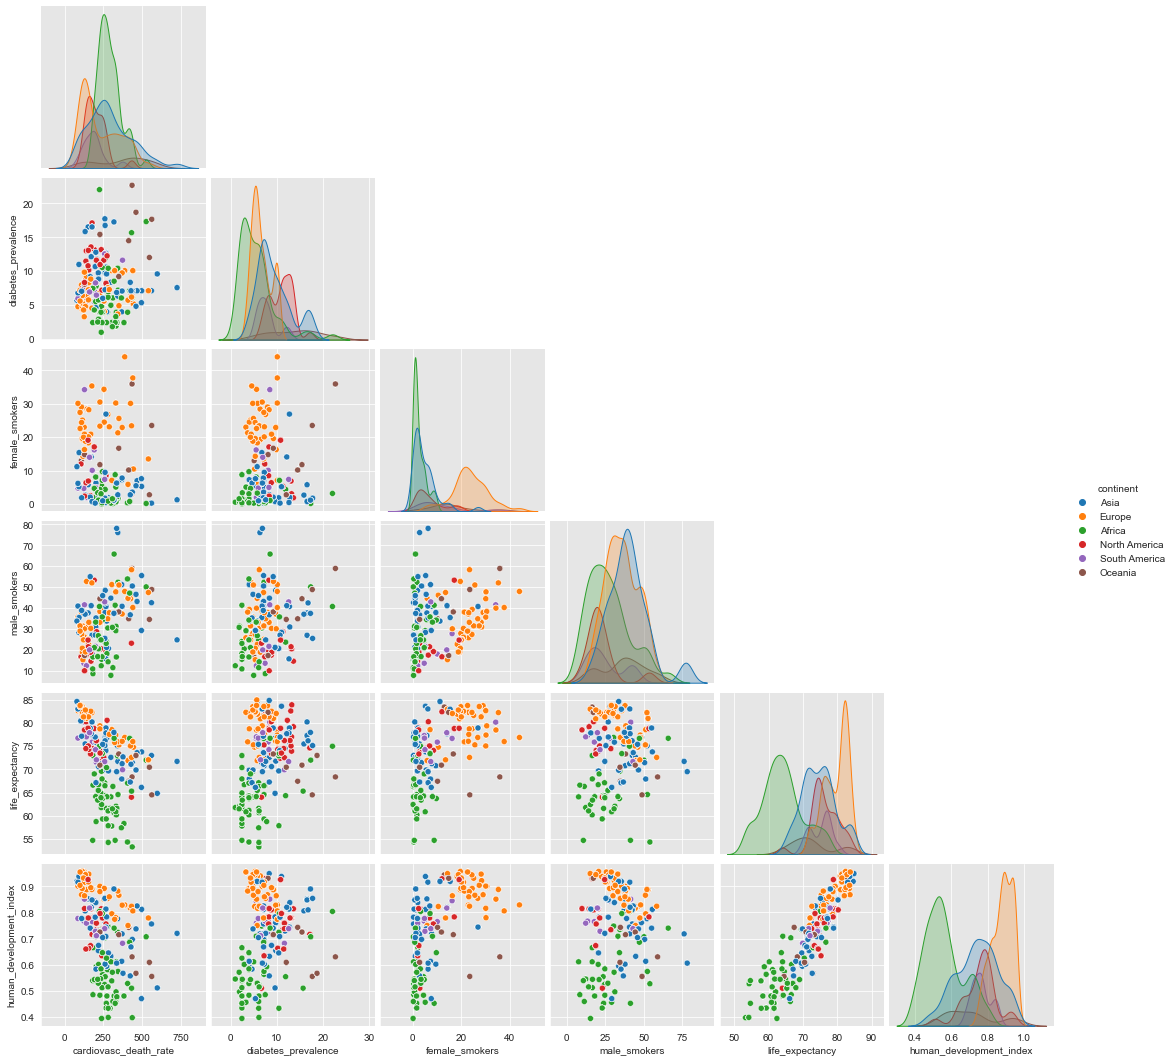

In [71]:
health_cols = [
    "continent", 
    "cardiovasc_death_rate", 
    "diabetes_prevalence", 
    "female_smokers", 
    "male_smokers", 
    "life_expectancy", 
    "human_development_index"] 

df_health = df.loc[:, health_cols]
sns.pairplot(df_health, hue="continent", corner=True)

In [72]:
df["human_development_index"].corr(df["life_expectancy"])

0.9120847433498297

### As life expectancy is one of the criteria in Human Development Index measurement, the graph shows a clear relationship between them. Therefore, it would be sensible to drop the `life_expectancy` feature

In [73]:
df.drop(["life_expectancy"], inplace=True, axis=1)

### Features with too many missing values can be safely removed because of the high positive correlation between other "independent" variable. 

### Now with other features, we will fill in the data

# Filling missing data

### In each continent, countries differ in many aspects such as population, human development index, GDP, and so on. For example China is a great outliner in Asia and most of countries with many missing values is somewhat developing countries with these aspects are in big difference compared to China. 

### Therefore, it would be better to fill in the missing value with the median of that feature in a continent, instead of mean if that country has the whole feature values missing. (Case 1) 

### Or we can use fill in the data with "similar" country by KNN (Case 2)

### Case 1: 

### Before filling in the value, notice that in Oceania, there are some features (`new_tests_smoothed_per_thousand`, `positive_rate`, `tests_per_case`, `total_boosters_per_hundred`, `handwashing_facilities`, and so on) exist in only one or two countries (Australia). For that reason, taking the median or mean in that continent is not a good idea.

### While it is better fit if we remove these data but we still fill in these countries in Oceania with median and carefully observe their result in the later step to compare the result with KNN

In [74]:
df_med = df.copy()


In [75]:
# Case 1:
applied_cols = list(df.columns)
df_group_iso = df_med.groupby(["iso_code"])
df_group_cont = df_med.groupby(["continent"])

for col_name, col_data in df_med.iteritems():
    if col_name == "iso_code" or col_name=="continent" or col_name=="date":
        continue
    df_med[col_name] = df_group_iso[col_name].apply(lambda x: x.fillna(x.mean()))
    df_med[col_name] = df_group_cont[col_name].apply(lambda x: x.fillna(x.median()))



### Now all the regressors values are filled in

In [76]:
df_med.isna().sum()

iso_code                               0
continent                              0
date                                   0
new_cases_per_million                  0
new_deaths_per_million                 0
new_tests_smoothed_per_thousand        0
positive_rate                          0
tests_per_case                         0
people_fully_vaccinated_per_hundred    0
stringency_index                       0
population_density                     0
median_age                             0
aged_65_older                          0
gdp_per_capita                         0
extreme_poverty                        0
cardiovasc_death_rate                  0
diabetes_prevalence                    0
female_smokers                         0
male_smokers                           0
hospital_beds_per_thousand             0
human_development_index                0
dtype: int64

### Case 2: KNN

In [77]:
df.columns

Index(['iso_code', 'continent', 'date', 'new_cases_per_million',
       'new_deaths_per_million', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case',
       'people_fully_vaccinated_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita',
       'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'human_development_index'],
      dtype='object')

In [78]:
df_knn = df.copy()
imputer = KNNImputer(weights='distance')
cols = df_knn.columns.tolist()
cols.remove("iso_code")
cols.remove("continent")
cols.remove("date")

df_knn.loc[:,cols] = imputer.fit_transform(df_knn.loc[:,cols])

In [79]:
df_knn.isna().sum()

iso_code                               0
continent                              0
date                                   0
new_cases_per_million                  0
new_deaths_per_million                 0
new_tests_smoothed_per_thousand        0
positive_rate                          0
tests_per_case                         0
people_fully_vaccinated_per_hundred    0
stringency_index                       0
population_density                     0
median_age                             0
aged_65_older                          0
gdp_per_capita                         0
extreme_poverty                        0
cardiovasc_death_rate                  0
diabetes_prevalence                    0
female_smokers                         0
male_smokers                           0
hospital_beds_per_thousand             0
human_development_index                0
dtype: int64

### Next, there are entries with 0 values in 2 prediction columns (`new_cases_per_million` and `new_death_per_million`). 

### New cases and death may not change too much in during a week so that if a country has at least 1 entry that is not zero then we can take the mean of these days as the value for day 7

In [80]:
def change_zero(data):
    data_copy = data.copy()
    df_group_iso = data_copy.groupby(["iso_code"])
    df_group_iso_mean = df_group_iso.mean()
 
    for iso, d in df_group_iso:    
        for col in ["new_cases_per_million", "new_deaths_per_million"]:
            data_copy.loc[data_copy["iso_code"] == iso, col].replace(0, np.nan, inplace=True)
            data_copy.loc[data_copy["iso_code"] == iso, col].fillna(df_group_iso_mean.at[iso, col], inplace=True)
        
            
    return data_copy


df_med_0 = change_zero(df_med)
df_knn_0 = change_zero(df_knn)

In [81]:
df_med.shape
df_knn.shape

(1323, 21)

### Next change categorical fields (`continent`) into boolean variable

In [82]:
def one_hot_code(data):
    indicator_cols = pd.get_dummies(data[["continent"]])
    data = pd.concat([data, indicator_cols], axis=1)
    data.drop(["continent"], axis=1, inplace=True)

    return data

df_med = one_hot_code(df_med)
df_knn = one_hot_code(df_knn)

In [83]:
df_med.to_csv("./med.csv")
df_knn.to_csv("./knn.csv")

# 2. Regression and Diagnostics for 2 tasks

In [84]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

array([[<AxesSubplot:title={'center':'new_cases_per_million'}>,
        <AxesSubplot:title={'center':'new_deaths_per_million'}>,
        <AxesSubplot:title={'center':'new_tests_smoothed_per_thousand'}>,
        <AxesSubplot:title={'center':'positive_rate'}>],
       [<AxesSubplot:title={'center':'tests_per_case'}>,
        <AxesSubplot:title={'center':'people_fully_vaccinated_per_hundred'}>,
        <AxesSubplot:title={'center':'stringency_index'}>,
        <AxesSubplot:title={'center':'population_density'}>],
       [<AxesSubplot:title={'center':'median_age'}>,
        <AxesSubplot:title={'center':'aged_65_older'}>,
        <AxesSubplot:title={'center':'gdp_per_capita'}>,
        <AxesSubplot:title={'center':'extreme_poverty'}>],
       [<AxesSubplot:title={'center':'cardiovasc_death_rate'}>,
        <AxesSubplot:title={'center':'diabetes_prevalence'}>,
        <AxesSubplot:title={'center':'female_smokers'}>,
        <AxesSubplot:title={'center':'male_smokers'}>],
       [<AxesSubplot

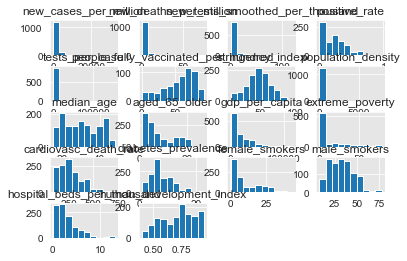

In [85]:
df.hist()

### As some features do not follow normal distribution, therefore, we will use min max scaler instead of standard scaler

In [86]:
def xy(data):
    df7 = data.loc[data['date'] == '2/7/2022', :].copy()
    df7 = df7.reset_index(drop="True")
    X = df7.drop(['iso_code', 'new_cases_per_million','new_deaths_per_million', "date"], inplace = False, axis = 1)
    cols = X.columns

    y0 = df7['new_cases_per_million']
    y1 = df7['new_deaths_per_million']

    return X, y0, y1, cols

X, y1, y2, cols = xy(df_med)
X = MinMaxScaler().fit_transform(X)
X = sm.add_constant(X)

const = pd.Index(["const"])
cols = const.append(cols)
X = pd.DataFrame(X, columns=cols)


### OLS statsmodels

In [87]:
r1 = sm.OLS(y1, X).fit()
r2 = sm.OLS(y2, X).fit()

pred1 = r1.predict(X)
pred2 = r2.predict(X)

In [88]:
print(r1.summary())

                              OLS Regression Results                             
Dep. Variable:     new_cases_per_million   R-squared:                       0.363
Model:                               OLS   Adj. R-squared:                  0.283
Method:                    Least Squares   F-statistic:                     4.532
Date:                   Sun, 05 Jun 2022   Prob (F-statistic):           1.02e-08
Time:                           12:42:03   Log-Likelihood:                -1683.4
No. Observations:                    189   AIC:                             3411.
Df Residuals:                        167   BIC:                             3482.
Df Model:                             21                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [89]:
print(r2.summary())

                              OLS Regression Results                              
Dep. Variable:     new_deaths_per_million   R-squared:                       0.297
Model:                                OLS   Adj. R-squared:                  0.209
Method:                     Least Squares   F-statistic:                     3.364
Date:                    Sun, 05 Jun 2022   Prob (F-statistic):           6.05e-06
Time:                            12:42:03   Log-Likelihood:                -553.66
No. Observations:                     189   AIC:                             1151.
Df Residuals:                         167   BIC:                             1223.
Df Model:                              21                                         
Covariance Type:                nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [90]:
# RMSE
print("RMSE")
print(f'new_cases_per_million:\t{r1.mse_total**0.5:.4f}')
print(f'new_deaths_per_million:\t{r2.mse_total**0.5:.4f}')

RMSE
new_cases_per_million:	2244.2053
new_deaths_per_million:	5.4170


# 3. P-value Interpretation

### As p-value is the probability of obtaining the observed results if H_O is true (which we need to reject), then the lower p-value is, the more important the coefficient is. 

### For instance, in new cases prediction, `positive_rate` with p-value 0.006 is a significant indicator. it is sensible that positive rate is an important factor in the number of new Covid19 cases. 

### while in new death prediction, `diabetes_prevalence` with p-value 0.043 is a significant indicator. It can be explained that diabetes is one of the factors that causes higher risk of mortality of covd19 patients  

# 4. Step-wise forward regression

In [91]:
import math
alpha = 0.05

def forward_stepwise(X, y):
    sig_cols = []
    remaining = [col for col in X.columns][1:]


    for i in range(X.shape[1]):
        best_col = None
        best_pvalue = math.inf
        for new_col in remaining:
            model = sm.OLS(y, X[["const"] + sig_cols + [new_col]]).fit()
            new_pvalue = model.pvalues[new_col]

            if model.pvalues[new_col] < best_pvalue:
                best_col = new_col
                best_pvalue = new_pvalue

        
        if best_col == None:
            break
        else:
            remaining.remove(best_col)
            sig_cols.append(best_col)

        model = sm.OLS(y, X[["const"] + sig_cols]).fit()
        if max(model.pvalues[1:]) > alpha:
            sig_cols.pop()
            break
    
    model = sm.OLS(y, X[["const"] + sig_cols]).fit()
    return model, sig_cols

    



In [92]:
mf1, cf1 = forward_stepwise(X, y1)
mf2, cf2 = forward_stepwise(X, y2)

### Forward Stepwise result for new cases

In [93]:
cf1

['continent_Europe',
 'gdp_per_capita',
 'positive_rate',
 'hospital_beds_per_thousand']

In [94]:
mf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     new_cases_per_million   R-squared:                       0.316
Model:                               OLS   Adj. R-squared:                  0.301
Method:                    Least Squares   F-statistic:                     21.24
Date:                   Sun, 05 Jun 2022   Prob (F-statistic):           2.04e-14
Time:                           12:42:04   Log-Likelihood:                -1690.1
No. Observations:                    189   AIC:                             3390.
Df Residuals:                        184   BIC:                             3407.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -168.8907    259.194     -0.652      0.515    -680.264     342.483
continent_Europe            1764.2553    421.134      4.189      0.000     933.383    2595.128
gdp_per_capita              3951.3195    902.664      4.377      0.000    2170.416    5732.223
positive_rate               2483.9201    847.149      2.932      0.004     812.546    4155.294
hospital_beds_per_thousand -1975.5387    970.778     -2.035      0.043   -3890.827     -60.251
==============================================================================
Omnibus:                      248.240   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18390.385
Skew:                           5.394   Prob(JB):                         0.00
Kurtosis:                      50.105   Cond. No.                         8.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Forward Stepwise result for new death

In [95]:
cf2

['female_smokers', 'diabetes_prevalence', 'continent_Oceania']

In [96]:
print(mf2.summary())

                              OLS Regression Results                              
Dep. Variable:     new_deaths_per_million   R-squared:                       0.232
Model:                                OLS   Adj. R-squared:                  0.219
Method:                     Least Squares   F-statistic:                     18.61
Date:                    Sun, 05 Jun 2022   Prob (F-statistic):           1.35e-10
Time:                            12:42:04   Log-Likelihood:                -562.08
No. Observations:                     189   AIC:                             1132.
Df Residuals:                         185   BIC:                             1145.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [97]:
# RMSE
print("RMSE")
print(f'new_cases_per_million:\t{mf1.mse_total**0.5:.4f}')
print(f'new_deaths_per_million:\t{mf2.mse_total**0.5:.4f}')

RMSE
new_cases_per_million:	2244.2053
new_deaths_per_million:	5.4170


# 5. Step-wise backward regression

In [98]:
alpha = 0.1

def backward_stepwise(X, y, alpha):
    cur_cols = list(X.columns)[1:]

    for i in range(X.shape[1]):

        model = sm.OLS(y, X[["const"] + cur_cols]).fit()
        max_p = max(model.pvalues[1:])

        if max_p > alpha:
            worst_feat = model.pvalues[1:].idxmax()
            cur_cols.remove(worst_feat)
        else:
            break
    
    model = sm.OLS(y, X[["const"] + cur_cols]).fit()
    return model, cur_cols


In [99]:
mb1, cb1 =  backward_stepwise(X, y1, alpha)
mb2, cb2 =  backward_stepwise(X, y2, alpha)

model1, sig_cols1 =  backward_stepwise(X, y1, alpha)

### Backward Stepwise result for new cases

In [100]:
cb1

['positive_rate',
 'gdp_per_capita',
 'cardiovasc_death_rate',
 'hospital_beds_per_thousand',
 'continent_Europe']

In [101]:
print(mb1.summary())

                              OLS Regression Results                             
Dep. Variable:     new_cases_per_million   R-squared:                       0.327
Model:                               OLS   Adj. R-squared:                  0.308
Method:                    Least Squares   F-statistic:                     17.75
Date:                   Sun, 05 Jun 2022   Prob (F-statistic):           2.50e-14
Time:                           12:42:05   Log-Likelihood:                -1688.7
No. Observations:                    189   AIC:                             3389.
Df Residuals:                        183   BIC:                             3409.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

### Backward Stepwise result for new death

In [102]:
cb2

['median_age',
 'gdp_per_capita',
 'diabetes_prevalence',
 'female_smokers',
 'continent_Africa']

In [103]:
print(mb2.summary())

                              OLS Regression Results                              
Dep. Variable:     new_deaths_per_million   R-squared:                       0.265
Model:                                OLS   Adj. R-squared:                  0.245
Method:                     Least Squares   F-statistic:                     13.22
Date:                    Sun, 05 Jun 2022   Prob (F-statistic):           5.36e-11
Time:                            12:42:06   Log-Likelihood:                -557.86
No. Observations:                     189   AIC:                             1128.
Df Residuals:                         183   BIC:                             1147.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [104]:
# RMSE
print("RMSE")
print(f'new_cases_per_million:\t{mb1.mse_total**0.5:.4f}')
print(f'new_deaths_per_million:\t{mb2.mse_total**0.5:.4f}')

RMSE
new_cases_per_million:	2244.2053
new_deaths_per_million:	5.4170


# 6. Difference between forward and backward regression

## Forward stepwise
### Beginning with a null model then gradually add the most significant variable to the model. The most significant variable depends on smallest p-value and a threshold

### When the number of features is large, forward stepwise can greatly reduce the time

## Backward stepwise

### Begining with a model with full features then gradually remove the least significant variables. The least significant variable is the largest p-value which is larger than a threshold. 

### Because backward stepwise considers all features at first and gradually removes features, it take all features' correlations simutaneously into consideration, thus may lead to more accurate result.

## New Cases

In [105]:
print(f"features in forward:")
print(cf1)
print()
print(f"features in backward")
print(cb1)


features in forward:
['continent_Europe', 'gdp_per_capita', 'positive_rate', 'hospital_beds_per_thousand']

features in backward
['positive_rate', 'gdp_per_capita', 'cardiovasc_death_rate', 'hospital_beds_per_thousand', 'continent_Europe']


In [106]:
print(f"RMSE in forward:")
print(f'new_cases_per_million:\t{mf1.mse_total**0.5:.4f}')
print()
print(f"RMSE in backward")
print(f'new_cases_per_million:\t{mb1.mse_total**0.5:.4f}')

RMSE in forward:
new_cases_per_million:	2244.2053

RMSE in backward
new_cases_per_million:	2244.2053


### In the prediction for new cases, there are almost same most important features in both backward and forward ('continent_Europe', 'gdp_per_capita', 'positive_rate', 'hospital_beds_per_thousand') and there is 'cardiovasc_death_rate' in the backward. The RMSE are roughly the same in both methods. 

## new death

In [107]:
print(f"features in forward:")
print(cf2)
print()
print(f"features in backward")
print(cb2)


features in forward:
['female_smokers', 'diabetes_prevalence', 'continent_Oceania']

features in backward
['median_age', 'gdp_per_capita', 'diabetes_prevalence', 'female_smokers', 'continent_Africa']


In [108]:
print(f"RMSE in forward:")
print(f'new_cases_per_million:\t{mf2.mse_total**0.5:.4f}')
print()
print(f"RMSE in backward")
print(f'new_cases_per_million:\t{mb2.mse_total**0.5:.4f}')

RMSE in forward:
new_cases_per_million:	5.4170

RMSE in backward
new_cases_per_million:	5.4170


### In the prediction for new death, the most significant features are diffirent to some extent; however there are shared features such as `female_smokers` and `diabetes_prevalence`. The RMSE are roughly the same in both methods. 

### `female_smokers` is the significant features in both methods which I found quite interesting and do not expect this result as I tend to combine `male_smokers` and `female_smokers` into one feature in the preprocessing part 